 # Reconstrured RecExpSim Notebook

 This is a recreation of the RecExpSim Notebook.
 It should be roughly similar to the existing notebook while using the new restructured codebase.

In [1]:
# Use biolabsim from parent folder.
import os
import sys
sys.path.append( os.path.abspath(os.path.join('.')) )
sys.path.append( os.path.abspath(os.path.join('..')) )



In [4]:
# 1. Set-up of simulation environment
import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.width = 100 # Make pandas output wider.

from silvio.outcome import combine_data
from silvio.catalog.recexpsim_original import RecExperiment

print('System ready')



System ready


In [17]:
# 2. Lab setup
exp = RecExperiment( equipment_investment=1500, seed=1 )
host = exp.create_host('ecol')
# print()
host.print_status()



Host [ecol.1]:
  seed plus counter = 4720721261117928062 + 0
  optimal growth temperature = 34
  max biomass = 48
  optimal primer length = 26
  Gene List: 0 genes
  Event History: 0 events


In [6]:
# 3.1. Experiment set-up
temperatures = [22,30,36,40] #[22,24,26,28,30]
print()
growth_out = exp.simulate_growth(host, temperatures)
growth_out.display_data()
growth_out.export_plot('output/Growth_Simulation.png')




############################################# progress of exp.0 at 22 °C: 100 percent
############################################# progress of exp.1 at 30 °C: 100 percent
############################################# progress of exp.2 at 36 °C: 100 percent
############################################# progress of exp.3 at 40 °C: 100 percent
    time [h]  exp.0 biomass conc. at 22 °C  exp.1 biomass conc. at 30 °C  \
0        0.0                      0.095314                      0.097038   
1        1.0                      0.110885                      0.179054   
2        2.0                      0.098243                      0.477944   
3        3.0                      0.138729                      0.812244   
4        4.0                      0.130317                      1.614099   
5        5.0                      0.108684                      4.089171   
6        6.0                      0.145477                      7.910813   
7        7.0                      0.136389     

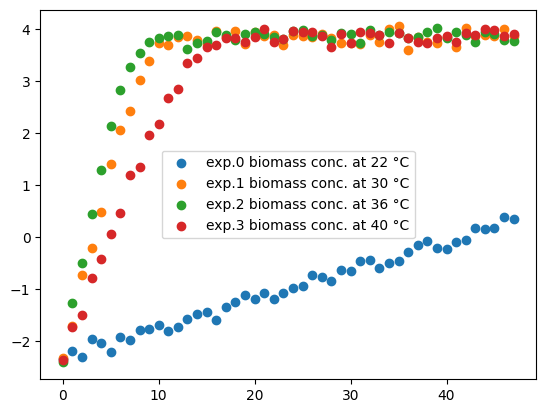

In [7]:
# 3.2.2.1 Visual analysis of exponential growth
growth_out.display_plot()



In [8]:
# 3.2.2.2 Determine maximum biomass and growth rate
Idx_optT, Linear_optT = 2, 6
# TODO: Maybe calculations of MB and GR are hidden inside the Outcome.
#   Maybe its intuitive to draw the chosen point in the plot.
cult_df = growth_out.value
Time, Biomass = cult_df.iloc[:,0], cult_df.iloc[:,1:]
LnBiomass = np.log(Biomass)
MB = np.mean(Biomass.iloc[Linear_optT:,Idx_optT])
GR = np.polyfit(Time.iloc[:Linear_optT],LnBiomass.iloc[:Linear_optT,Idx_optT],1)
print()
print('max biomass: {:.0f}\nmax growth rate: {:.2f}'.format(MB,GR[0]))




max biomass: 46
max growth rate: 0.90


In [9]:
# 4.1.1 Promoter choice and cloning
from silvio.extensions.records.gene.crafted_gene import CraftedGene
from Bio.Seq import Seq
Promoter1 = Seq("GCCCAAAAAAAAAGCAAACACGTAAAGGAAAAAATGCACG")
Primer1 =   Seq("CGGGTTTTTTTTTCG")
Tm =        48 # melting temperature
NewGene = CraftedGene( name="MyGenA", prom=Promoter1, orf="GGGGGGGGGG" )

print("\nTry cloning with bad melting temperature.")
# TODO: Melting temperature is not affecting clone chance.
bad_host, clone_outcome = exp.clone_with_recombination( host, Primer1, gene=NewGene, tm=1000 )
print("Clone Outcome: " + clone_outcome)

print("\nTry cloning first with good parameters.")
good_host_a, clone_outcome = exp.clone_with_recombination( host, Primer1, gene=NewGene, tm=Tm )
print("Clone Outcome: " + clone_outcome)
good_host_a.print_status()

Promoter2 = Seq("GCCCAAATATTAAGCAAACACGTAAAGGAAAAAATGCACG")
Primer2 =   Seq("CGGGTTTATAATTCG")
Tm2 =       52
NewGene2 = CraftedGene( name="MyGenB", prom=Promoter2, orf="GGGGGGGGGG" )

print("\nTry cloning second with good parameters.")
good_host_b, clone_outcome = exp.clone_with_recombination( host, Primer2, gene=NewGene2, tm=Tm2 )
print("Clone Outcome: " + clone_outcome)
good_host_b.print_status()




Try cloning with bad melting temperature.
Clone Outcome: Cloning with recombination succeeded.

Try cloning first with good parameters.
Clone Outcome: Cloning with recombination succeeded.
Host [ecol.1.2]:
  seed plus counter = 6733855923820810058 + 0
  optimal growth temperature = 34
  max biomass = 48
  optimal primer length = 26
  Gene List: 1 genes
  - MyGenA = GCCCAAAAAAAAAGCAAACACGTAAAGGAAAAAATGCACG * GGGGGGGGGG
  Event History: 1 events
  - Added gene=MyGenA to the GenomeLibrary.

Try cloning second with good parameters.
Clone Outcome: Cloning with recombination succeeded.
Host [ecol.1.3]:
  seed plus counter = 3002399975030559795 + 0
  optimal growth temperature = 34
  max biomass = 48
  optimal primer length = 26
  Gene List: 1 genes
  - MyGenB = GCCCAAATATTAAGCAAACACGTAAAGGAAAAAATGCACG * GGGGGGGGGG
  Event History: 1 events
  - Added gene=MyGenB to the GenomeLibrary.


In [10]:
# 4.1.2 Measurement of the promoter strength
prom_out_1 = exp.measure_promoter_strength( bad_host, NewGene )

prom_out_2 = exp.measure_promoter_strength( good_host_a, NewGene )

prom_out_3 = exp.measure_promoter_strength( good_host_b, NewGene ) # Use NewGene but HostB only has NewGene2

prom_out_4 = exp.measure_promoter_strength( good_host_b, NewGene2 )

# Join all measurements.
print("\nAll Promoter Strengths combined:")
all_prom_out = combine_data([ prom_out_1, prom_out_2, prom_out_3, prom_out_4 ])
all_prom_out.display_data()




All Promoter Strengths combined:
       Host GeneName                              GenePromoter  PromoterStrength
0  ecol.1.1   MyGenA  GCCCAAAAAAAAAGCAAACACGTAAAGGAAAAAATGCACG              1.06
1  ecol.1.2   MyGenA  GCCCAAAAAAAAAGCAAACACGTAAAGGAAAAAATGCACG              1.06
2  ecol.1.3   MyGenA  GCCCAAAAAAAAAGCAAACACGTAAAGGAAAAAATGCACG              0.00
3  ecol.1.3   MyGenB  GCCCAAATATTAAGCAAACACGTAAAGGAAAAAATGCACG              0.72


/home/ulf/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/ulf/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/ulf/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/ulf/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from versio

In [11]:
# 4.1.3 Measurement of the final vaccine expression rate
# in Make_ProductionExperiment: Clone_ID (string), Opt. Temp (int), Opt. Growth rate (float), Opt. Biomass (int)

vac_out_1 = exp.simulate_vaccine_production( good_host_a, gene=NewGene, cult_temp=26, growth_rate=0.76, biomass=46 )
print('Vaccine production rate A, try 1: (error:{})'.format( vac_out_1.error ))

vac_out_2 = exp.simulate_vaccine_production( good_host_a, gene=NewGene, cult_temp=36, growth_rate=0.92, biomass=46 )
print('Vaccine production rate A, try 2: (error:{})'.format( vac_out_2.error ))

vac_out_3 = exp.simulate_vaccine_production( good_host_b, gene=NewGene2, cult_temp=36, growth_rate=0.92, biomass=70 )
print('Vaccine production rate B, try 1: (error:{})'.format( vac_out_3.error ))

vac_out_4 = exp.simulate_vaccine_production( good_host_b, gene=NewGene2, cult_temp=36, growth_rate=0.92, biomass=46 )
print('Vaccine production rate B, try 2: (error:{})'.format( vac_out_4.error ))

# Its possible to make a custom combine_data for the production experiments.
all_vac_out = combine_data([ vac_out_1, vac_out_2, vac_out_3, vac_out_4 ])
all_vac_out.display_data()
all_vac_out.export_data('output/Production_Experiments.csv')



Vaccine production rate A, try 1: (error:Maximum biomass and/or maximum growth rate are incorrect.)
Vaccine production rate A, try 2: (error:None)
Vaccine production rate B, try 1: (error:Maximum biomass and/or maximum growth rate are incorrect.)
Vaccine production rate B, try 2: (error:None)
       Host Gene_Name                         Promoter_Sequence  Promoter_GC-content  \
0  ecol.1.2    MyGenA  GCCCAAAAAAAAAGCAAACACGTAAAGGAAAAAATGCACG                0.375   
1  ecol.1.2    MyGenA  GCCCAAAAAAAAAGCAAACACGTAAAGGAAAAAATGCACG                0.375   
2  ecol.1.3    MyGenB  GCCCAAATATTAAGCAAACACGTAAAGGAAAAAATGCACG                0.375   
3  ecol.1.3    MyGenB  GCCCAAATATTAAGCAAACACGTAAAGGAAAAAATGCACG                0.375   

   Expression_Temperature  Expression_Biomass  Expression_Rate  
0                      26                  46             0.00  
1                      36                  46             0.34  
2                      36                  70             0.00  
3    

/home/ulf/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/ulf/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/ulf/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/ulf/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from versio

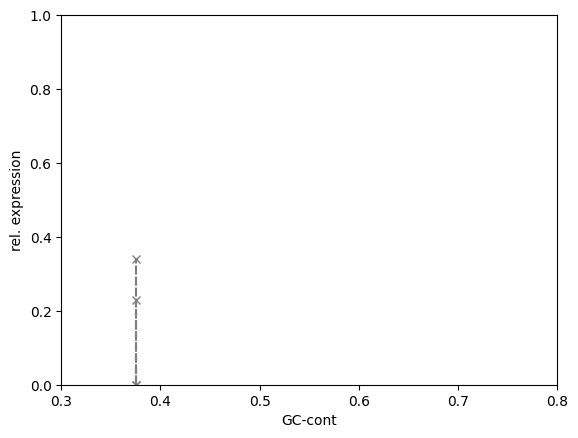

In [12]:
# 4.2.1 Visualization of the results
# TODO: This could be a new DataWithPlotOutcome to hide the code if wanted.
GCcont, Express = all_vac_out.value['Promoter_GC-content'], all_vac_out.value['Expression_Rate']
plt.plot(GCcont,Express, linestyle = '--', marker = 'x', color = 'grey')
plt.gca().set(xlabel='GC-cont', ylabel='rel. expression', xlim=(.3,.8), ylim=(0,1))
plt.savefig('output/RelExpress_Vs_GCcont_allProm.png', format='png')
plt.show()


In [13]:
# Print internal state.
exp.print_status()
for h in exp.hosts :
    h.print_status()

Experiment:
  budget = 5400
  failure rate = 0.12903225806451613
  no. hosts = 4
Host [ecol.1.2]:
  seed plus counter = 6733855923820810058 + 0
  optimal growth temperature = 34
  max biomass = 48
  optimal primer length = 26
  Gene List: 1 genes
  - MyGenA = GCCCAAAAAAAAAGCAAACACGTAAAGGAAAAAATGCACG * GGGGGGGGGG
  Event History: 1 events
  - Added gene=MyGenA to the GenomeLibrary.
Host [ecol.1.3]:
  seed plus counter = 3002399975030559795 + 0
  optimal growth temperature = 34
  max biomass = 48
  optimal primer length = 26
  Gene List: 1 genes
  - MyGenB = GCCCAAATATTAAGCAAACACGTAAAGGAAAAAATGCACG * GGGGGGGGGG
  Event History: 1 events
  - Added gene=MyGenB to the GenomeLibrary.
Host [ecol.1]:
  seed plus counter = 4720721261117928062 + 4
  optimal growth temperature = 34
  max biomass = 48
  optimal primer length = 26
  Gene List: 0 genes
  Event History: 0 events
Host [ecol.1.1]:
  seed plus counter = 8765106411078559354 + 0
  optimal growth temperature = 34
  max biomass = 48
  optim